# Random Number

### Problem 1 - Random Number Generator in Standard C Library

In [13]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Importing Necessary Libraries
import numpy as np
%matplotlib notebook
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

<IPython.core.display.Javascript object>


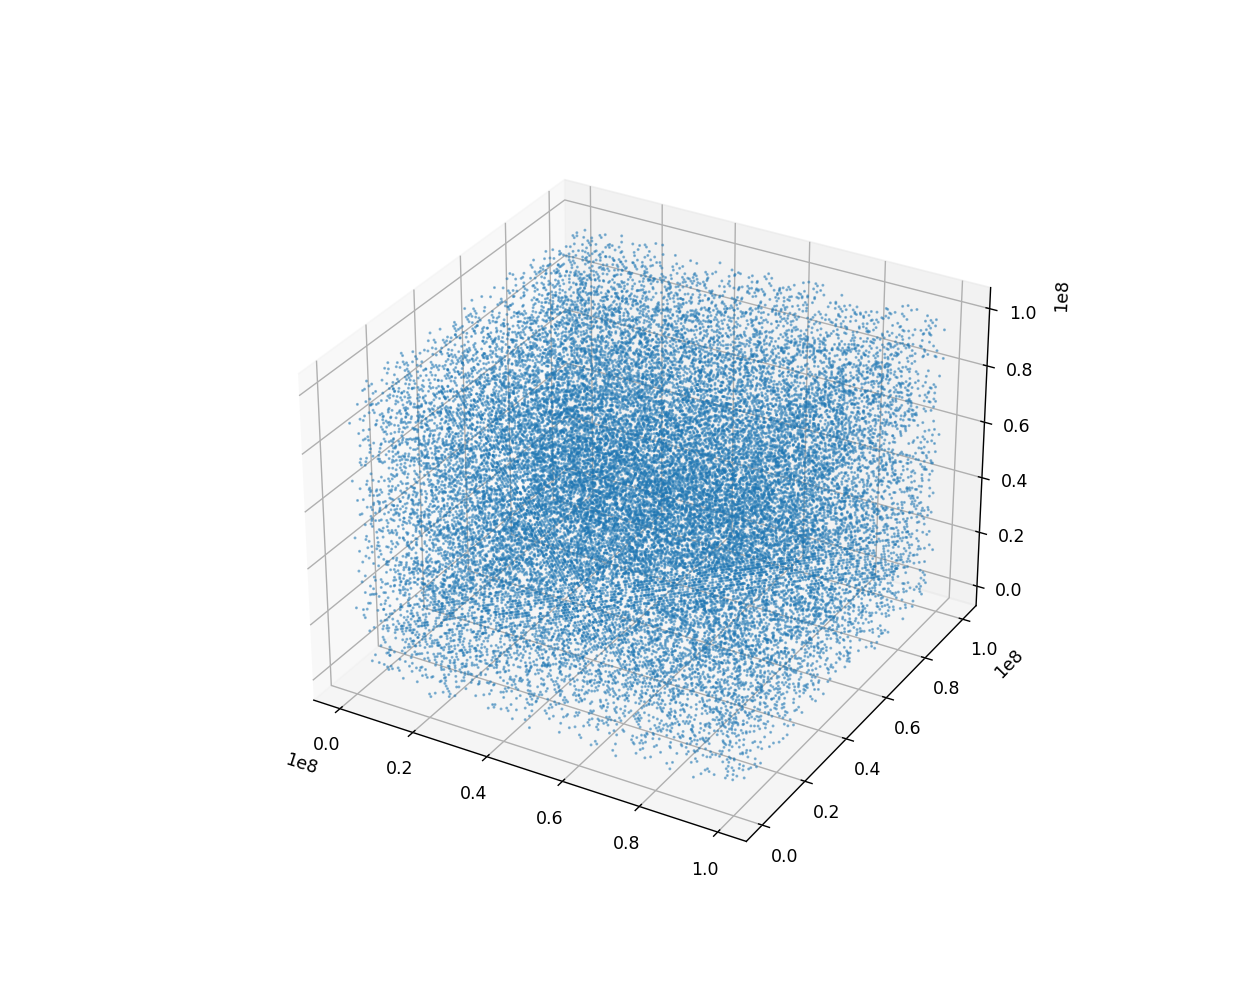

In [2]:
data = np.loadtxt('rand_points.txt')
x = data[:,0]
y = data[:,1]
z = data[:,2]

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z,s=0.5,alpha=0.5)
plt.show()

The below images are taken by changing the view angle of the above 3D plot

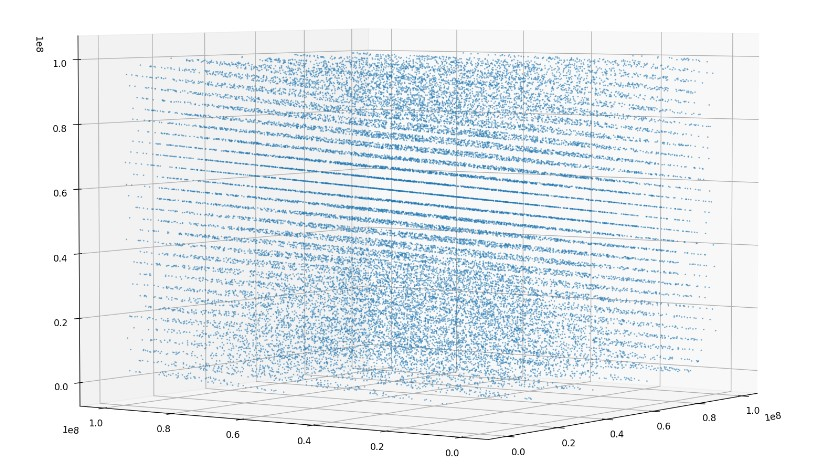

$$ \text{Figure 1} $$

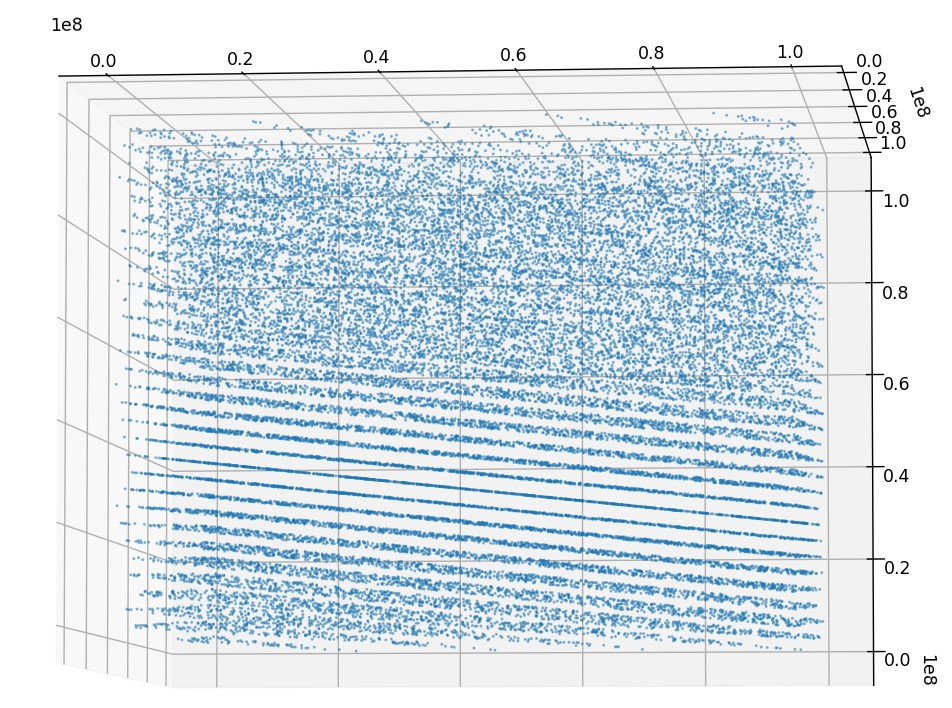

$$ \text{Figure 2} $$

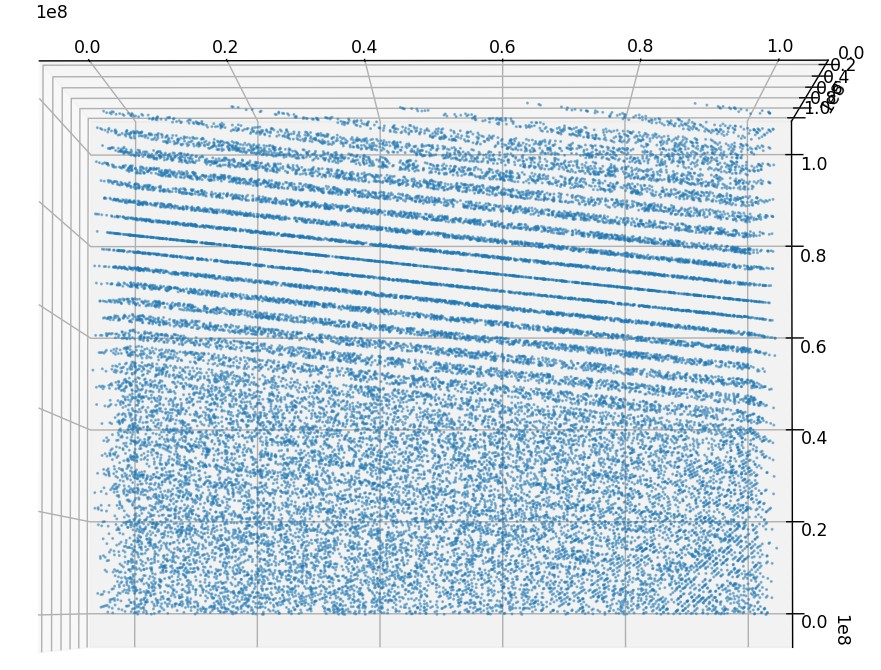

$$ \text{Figure 3} $$

We see that x,y,z triples lie along a set of planes and hence not very much randomly sampled. Now, Let's see the same effect with python's random number generator

<IPython.core.display.Javascript object>


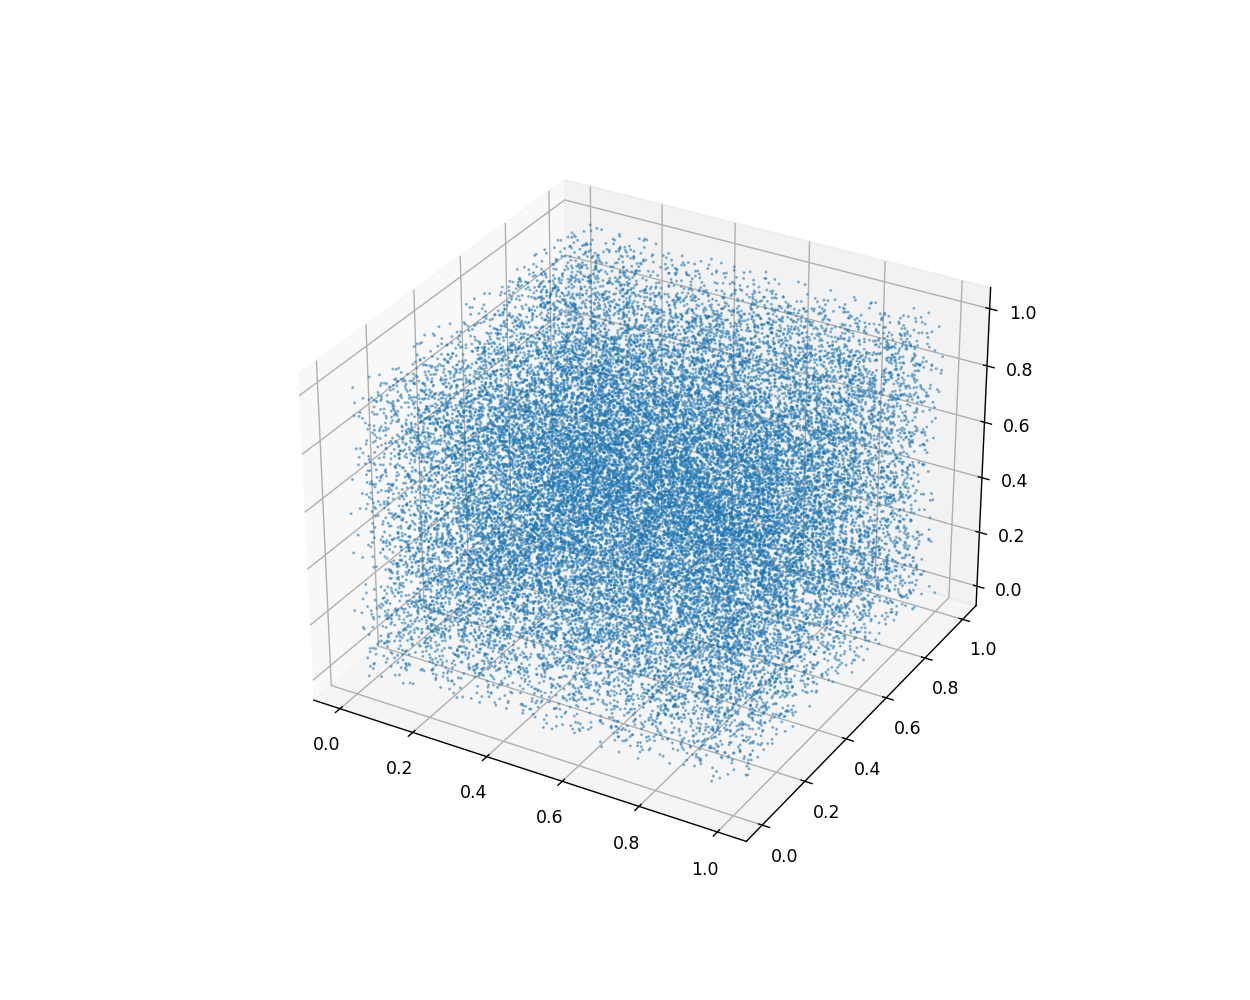

In [3]:
import numba as nb

@nb.njit
def rand_assign(vals): # Gets an array from 'get_rands' and assigns a random number for each entry
    n=len(vals)
    for i in range(n):
        vals[i]=np.random.rand()  # Here, we use python numpy's random library
    return vals

def get_rands(n):   # Creates a vector of length 'n' and passes it to 'rand_assign'
    vec=np.empty(n)
    vec = rand_assign(vec)
    return vec

N = 30000
vec = get_rands(N*3)

vv = np.reshape(vec,[N,3])

f=open('rand_points_python.txt','w')
for i in range(vv.shape[0]):
    myline=repr(vv[i,0])+' '+repr(vv[i,1])+' '+ repr(vv[i,2])+'\n'
    f.write(myline)
f.close()

file = np.loadtxt('rand_points_python.txt')
x = file[:,0]
y = file[:,1]
z = file[:,2]

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z,s=0.5,alpha=0.5)
plt.show()

I see that with python numpy's random library, the random samples are not lying along the planes, thus, randomly sampled! Now, let's try and see if we get the same effect from the standard C library in this machine.

<IPython.core.display.Javascript object>


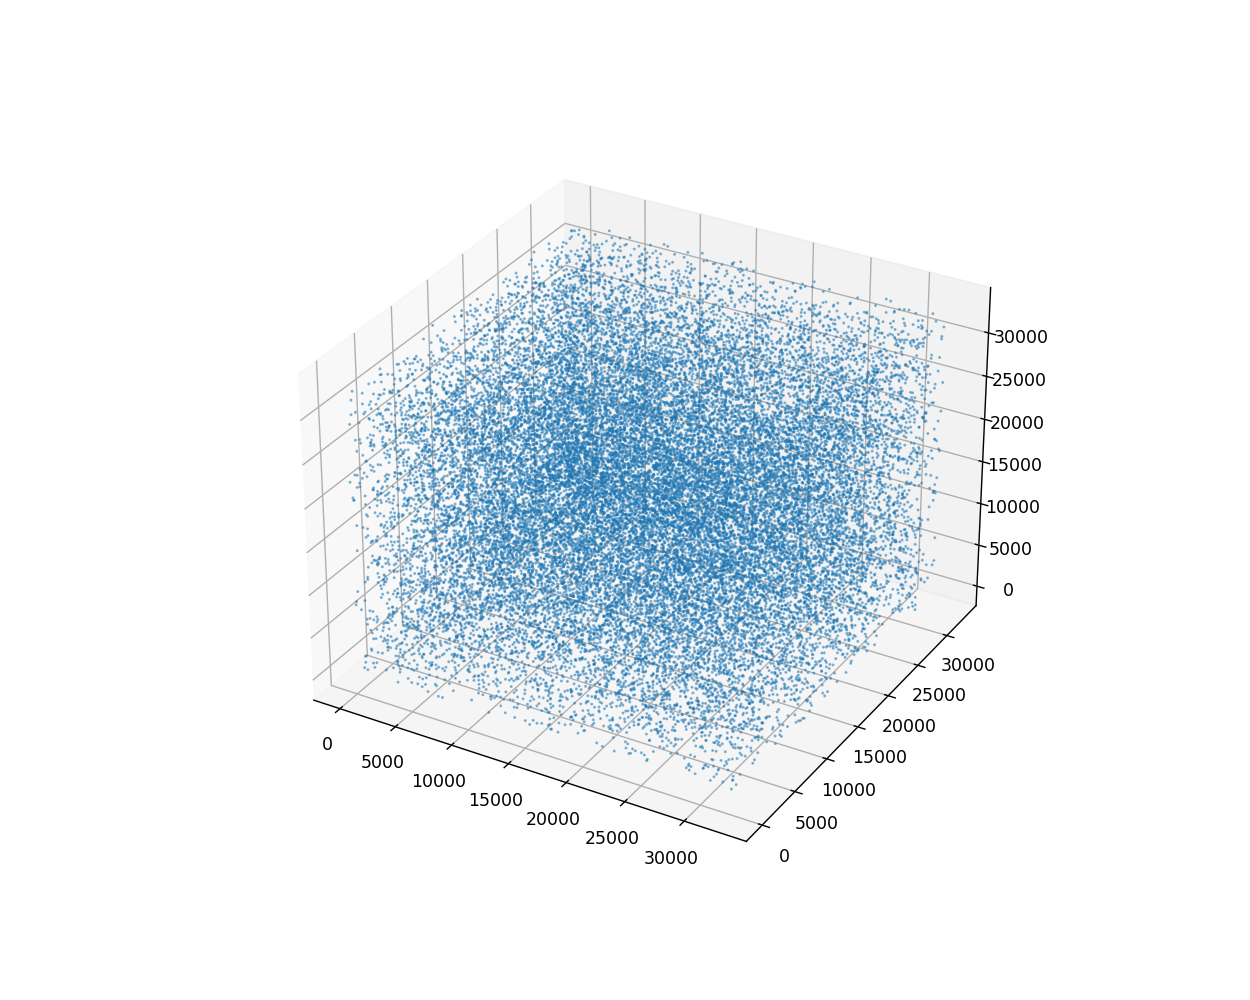

In [4]:
import ctypes
# Since, this notebook runs in a windows OS, the following method is used to import the C libraries
from ctypes import *    
libc = cdll.msvcrt

rand=libc.rand
rand.argtypes=[]
rand.restype=ctypes.c_int

@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec


n=30000
vec=get_rands(n*3)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

f=open('rand_points_C.txt','w')
for i in range(vv2.shape[0]):
    myline=repr(vv2[i,0])+' '+repr(vv2[i,1])+' '+ repr(vv2[i,2])+'\n'
    f.write(myline)
f.close()

data = np.loadtxt('rand_points_C.txt')
x = data[:,0]
y = data[:,1]
z = data[:,2]

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z,s=0.5,alpha=0.5)
plt.show()

I conclude that I don't see the same effect in my machine using the standard C library! 

### Problem 2 - Rejection Method to generate exponential deviates

For a exponential function, its probability density function is given as, $ e^{-x}$  for $x$ >= 0

Then, the cummulative density function is,

$$ \int_0 ^x e^{-x} dx= -e^{-x} $$ 

Let, the CDF be generated from a random number generator (r) from 0 to 1. Then, $r = -e^{-x}$. From this, we can get the value of $x$ as $ x = -log(r) $

Now, for the rejection method,  we want to generate numbers from the following distribution 

$$ f(x) = e^{-x}$$

For the boundary distribution $g(x)$, let's first see gaussian! The probability density function of a gaussian is,

$$  \frac{1}{\sqrt{2\pi}}e^{\frac{-x^2}{2}}  $$

Here, $f(x)$ is of order $e^{-x}$ whereas $g(x)$ is of order $e^{-x^2}$. Now, let's check whether gaussian can  be greater than $e^{-x}$ for all $x$

$$ \lim_{𝑥→∞}\frac{𝑒^{−𝑥}}{𝑒^{−𝑥^2}}=\lim_{𝑥→∞}(𝑒^{𝑥^2−𝑥})= \lim_{𝑥→∞}⁡(𝑒^{𝑥^2})= ∞ $$

Hence, the exponential is always infinitely bigger than the gaussian! Now, let's check Lorentzian! The probability density function of a lorentzian is,

$$  \frac{1}{1+x^2}  $$

The cummulative density function is,

$$  \int \frac{1}{1+x^2} dx = tan^{-1}(x)  $$

Since, $tan^{-1}(-∞) = -\pi/2$, the normalised CDF $(r)$ is $\frac {tan^{-1}(x)}{\pi + 1/2}$. Thus, $ x = tan(\pi(r-1/2))$ where $r$ is the CDF

<IPython.core.display.Javascript object>


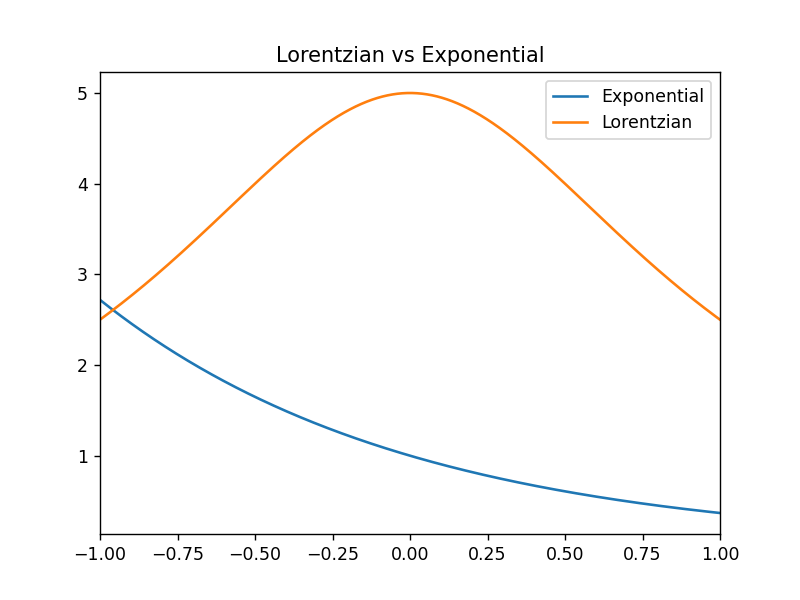

<IPython.core.display.Javascript object>


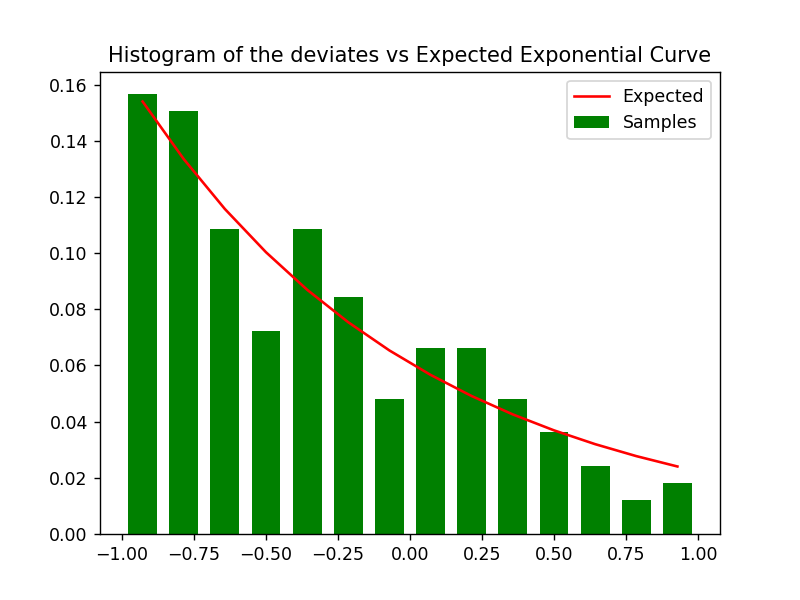

The Efficiency is 21.0% 


In [20]:
import numpy as np
from matplotlib import pyplot as plt

# Let's generate Lorentzian Random Numbers using the above derivation
def random(n):
    x = np.pi*(np.random.rand(n)-0.5)
    return np.tan(x)

N = 1000
# Generate random loretnzian and uniform numbers
ys = random(N)
us = np.random.rand(N)
M = 5 # This is a scaling factor just to ensure our g(x) > f(x)

fs = np.exp(-ys)   # Exponential probabilities of the random numbers
gs = 1/(1 + ys**2) # Lorentzian probabilities of the random numbers
# This is the Rejection Step...
keep = us < (fs / (M * gs))
exp_rands = ys[keep]

# Let's plot the results...

xs = np.linspace(-1,1,1000)
plt.figure()
plt.plot(xs,np.exp(-xs),label='Exponential')
plt.plot(xs,M*(1/(1 + xs**2)), label='Lorentzian')
plt.xlim([-1,1])
plt.title('Lorentzian vs Exponential')
plt.legend()
plt.show()

a,b = np.histogram(exp_rands,np.linspace(-1,1,15))
b = 0.5*(b[1:]+b[:-1])
pred = np.exp(-b)
pred = pred/pred.sum()
a = a/a.sum()
plt.figure()
plt.plot(b,pred,label = 'Expected',color='r')
plt.bar(b,a,0.1,label='Samples',color='g')
plt.title('Histogram of the deviates vs Expected Exponential Curve')
plt.legend()
plt.show()

# To find the efficiency in terms of the fraction of the uniform deviates
print(f'The Efficiency is {len(exp_rands)/(2*len(ys)) * 100}% ')

Thus, from the above plot, we see that the histogram of the deviates matches up well with the expected exponential curve! Also, this generator is found to be 22.05% efficient in terms of the fraction of the uniform deviates

### (c) Ratio of Uniforms Generator

Let's repeat the same scenario in problem 2 using ratio of uniforms. To find the limits on '$v$',

We should have $u < e^{-r}$ where $r = v/u$

Hence, $ log(u) = -r = -(v/u)$. From this,

$ v = u * (-log(u)) $

<IPython.core.display.Javascript object>


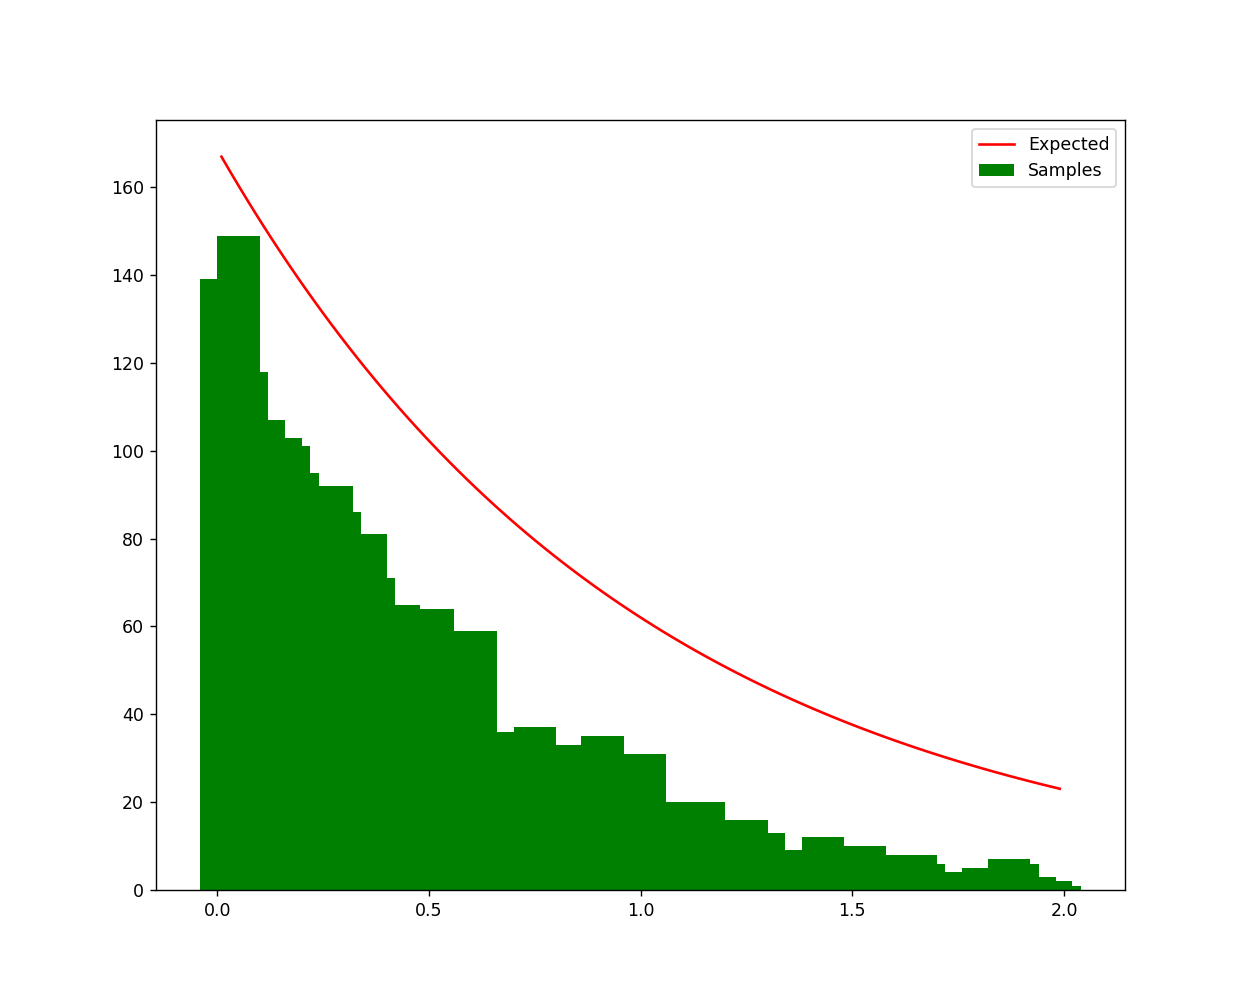

The efficiency is 50.0% Efficient


In [16]:
u = np.linspace(0,1,2001)[1:]
v = u*(-np.log(u))
v_max = v.max()

N=10000
u = np.random.rand(N)
v = (np.random.rand(N)*2-1)*v_max
r = v/u
accept = u<np.exp(-r)
exp = r[accept]

a,b = np.histogram(exp,100,range=(0,2))
b = 0.5*(b[1:]+b[:-1])
pred = (np.exp(-b)*np.sum(accept)*(b[2]-b[1]))
plt.figure(figsize=(10,8))
plt.bar(b,a,0.1,color='g',label='Samples')
plt.plot(b,pred,color='r',label='Expected')
plt.legend()
plt.show()

print(f'The efficiency is {len(r)/(2*len(u)) * 100}% Efficient')

Thus, the efficiency is 50 % in terms of the number of exponential deviates produced per uniform deviate. Also, the histogram matches up with the expected exponential curve!